In [338]:
# General libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import gamma
from calendar import month

# Load both datasets and add the City column
toronto = pd.read_csv("Data/Toronto.csv")
zurich = pd.read_csv("Data/Zurich.csv")

toronto['City'] = 'Toronto'
zurich['City'] = 'Zurich'

# Combine datasets
Weather = pd.concat([toronto, zurich], ignore_index=True)

Weather = Weather.set_index("date")

# Set to datetime format
Weather.index = pd.to_datetime(Weather.index)
Weather = Weather.iloc[1:]

Weather.head()

,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,City
date,,,,,,,,,,,,,,,,,,,,,
1940-01-01,3.0,6.126,-9.074,-0.876083,1.776848,-14.286230,-5.470793,0,0,32450.049,27957.854,0.0,0.0,0.0,0.0,9.585739,17.640000,200.00162,7.70,1.230151,Toronto
1940-01-02,3.0,8.126,-6.074,1.507250,3.680511,-11.067808,-3.297134,0,0,32502.955,28016.191,0.0,0.0,0.0,0.0,21.325253,38.519997,231.87212,7.50,1.541658,Toronto
1940-01-03,3.0,8.176,-2.474,2.417667,4.491743,-6.928890,-1.686686,0,0,32559.816,28076.562,0.0,0.0,0.0,0.0,19.373219,32.399998,170.99153,7.51,1.220417,Toronto
1940-01-04,3.0,7.776,-2.274,2.119750,3.619497,-6.844409,-1.950612,0,0,32620.550,26112.473,0.0,0.0,0.0,0.0,11.503113,21.960000,133.55592,6.66,1.134463,Toronto
1940-01-05,3.0,9.826,-2.324,4.176000,5.920227,-6.993218,-0.336941,0,0,32685.096,27424.092,0.0,0.0,0.0,0.0,22.331610,43.199997,246.32810,7.27,1.578667,Toronto


In [257]:
Weather.columns

Index(['weather_code', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean', 'sunrise',
       'sunset', 'daylight_duration', 'sunshine_duration', 'precipitation_sum',
       'rain_sum', 'snowfall_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_gusts_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'City',
       'Season'],
      dtype='object')

In [340]:
#function for mapping of seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
data_mean_temp = Weather["temperature_2m_mean"].mean()
# Add a Season column to the original data
Weather['Season'] = Weather.index.month.map(get_season)

#DROUGHT INDEX how much water evaporates vs comes in by rain/snow
Weather["drought_index"] = Weather["et0_fao_evapotranspiration"]-Weather["precipitation_sum"]

#SUN
# Calculate sunlight percentage
Weather["sunlight_percentage"] = (Weather["sunshine_duration"] / Weather["daylight_duration"]) * 100

# Group by City, Year, and Season
weather_aggregation = Weather.groupby(['City', Weather.index.year, 'Season']).agg(
    mean_temp=('temperature_2m_mean', 'mean'),
    max_temp=('temperature_2m_max', 'max'),
    min_temp=('temperature_2m_min', 'min'),
    temp_sd=('temperature_2m_mean', 'std'),
    mean_daylight_duration=('daylight_duration', 'mean'),
    mean_sunshine_duration=('sunshine_duration', 'mean'),
    total_precipitation=('precipitation_sum', 'sum'),
    total_rain=('rain_sum', 'sum'),
    total_snowfall=('snowfall_sum', 'sum'),
    precipitation_hours=('precipitation_hours', 'sum'),
    max_wind_speed=('wind_speed_10m_max', 'max'),
    mean_wind_speed=('wind_speed_10m_max', 'mean'),
    max_wind_gust=('wind_gusts_10m_max', 'max'),
    wind_speed_sd=('wind_speed_10m_max', 'std'),
    wind_gust_sd=('wind_gusts_10m_max', 'std'),
    mean_shortwave_radiation=('shortwave_radiation_sum', 'mean'),
    mean_et0_evapotranspiration=('et0_fao_evapotranspiration', 'mean'),
    mean_sunlight_percentage=("sunlight_percentage", "mean"),
    sd_sunlight_percentage=("sunlight_percentage", "std"),
    mean_drought_index=("drought_index", "mean"),
    sd_drought_index=("drought_index", "std"),
)

# Reset the index for easier access
weather_aggregation.index.set_names(['City', 'Year', 'Season'], inplace=True)
weather_aggregation = weather_aggregation.reset_index()


#WIND
lta_windpseed_zurich = Weather["wind_speed_10m_max"].mean()
weather_aggregation["windiness_index"] =(weather_aggregation["mean_wind_speed"]/lta_windpseed_zurich)*100


# Display
weather_aggregation.head()

,City,Year,Season,mean_temp,max_temp,min_temp,temp_sd,mean_daylight_duration,mean_sunshine_duration,total_precipitation,total_rain,total_snowfall,precipitation_hours,max_wind_speed,mean_wind_speed,max_wind_gust,wind_speed_sd,wind_gust_sd,mean_shortwave_radiation,mean_et0_evapotranspiration,mean_sunlight_percentage,sd_sunlight_percentage,mean_drought_index,sd_drought_index,windiness_index
0,Toronto,1940,Fall,10.187722,31.976,-8.624000,7.650400,39589.074055,32509.836477,29.900005,28.900005,0.70,103.0,42.796112,18.600842,77.40000,8.829548,14.899133,13.055824,2.921067,81.849389,18.568284,2.592496,2.290511,120.276365
1,Toronto,1940,Spring,13.022490,33.376,-5.274000,6.735502,48378.922326,38913.675546,38.200001,37.200001,0.70,152.0,49.044632,22.791118,88.20000,8.880703,14.681547,21.175870,4.633723,80.529236,19.030063,4.218506,2.191769,147.371433
2,Toronto,1940,Summer,26.679986,38.976,12.326000,2.981221,53090.655489,45012.720138,12.300001,12.300001,0.00,75.0,38.886665,19.712759,66.96000,8.056656,12.449319,24.748587,7.188433,84.846290,15.213482,7.054737,1.805141,127.466214
3,Toronto,1940,Winter,-1.946024,14.126,-19.424002,4.482088,34648.071011,27202.052468,10.100000,5.400000,3.29,58.0,40.513992,17.180478,77.03999,8.323459,14.304969,8.715714,1.217025,78.246252,17.791508,1.106036,0.581996,111.092036
4,Toronto,1941,Fall,12.967232,30.976,-8.124000,8.226065,39626.751835,32561.565012,21.900000,20.500000,0.98,86.0,43.973083,17.406026,81.72000,8.723564,14.590170,12.998352,3.106804,81.427468,17.339116,2.866145,2.197150,112.550467


In [274]:
#computer long term average windspeed for Windiness indey
lta_windpseed = Weather.groupby("City")["wind_speed_10m_max"].mean()
lta_windpseed

City
Toronto    19.493129
Zurich     11.437042
Name: wind_speed_10m_max, dtype: float64

## Temperature Analysis

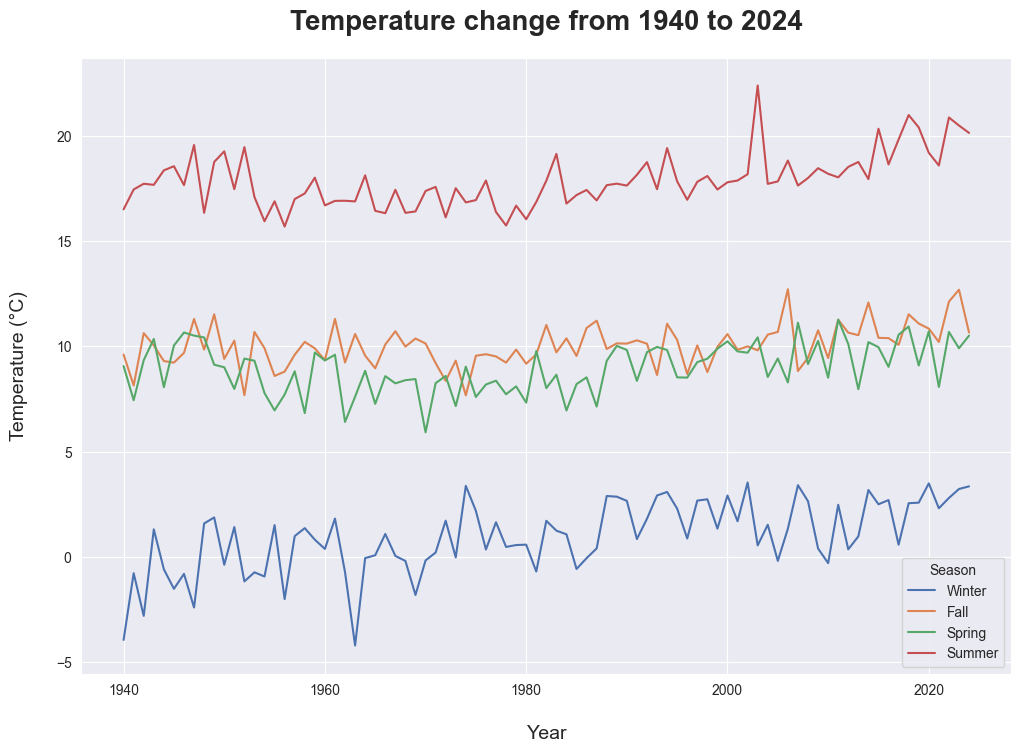

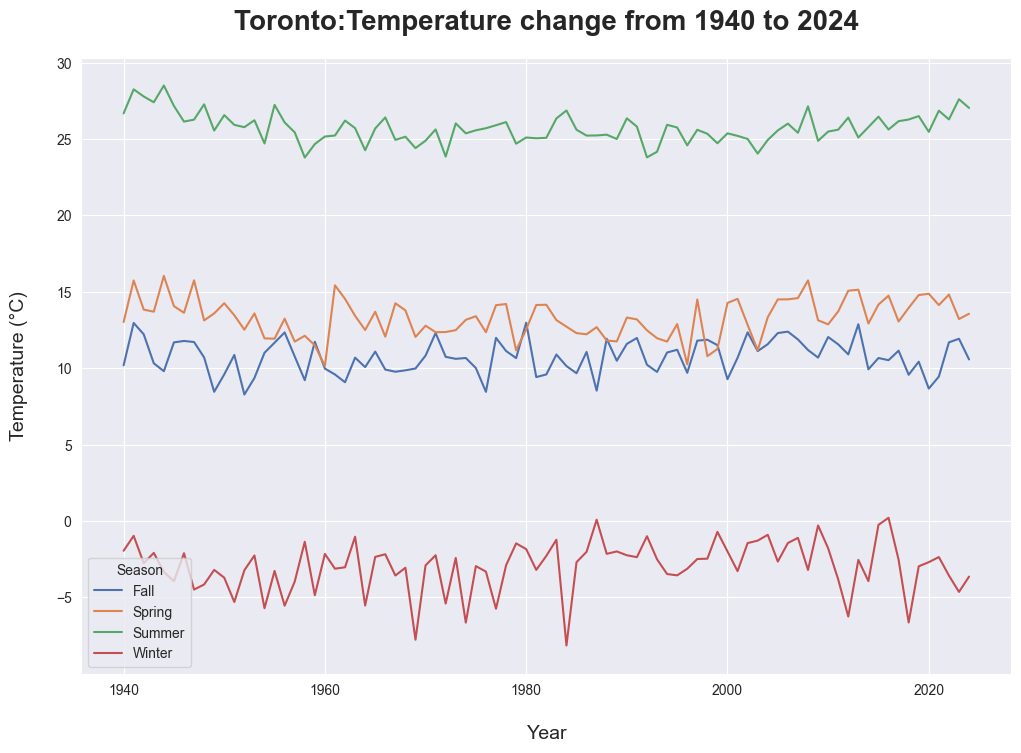

In [288]:
#Temperature Change in Zurich
plt.figure(figsize=(12, 8))
sns.lineplot(data=weather_aggregation[weather_aggregation["City"] == "Zurich"], x="Year", y="mean_temp", hue="Season", palette="deep")
plt.title('Temperature change from 1940 to 2024', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)  
plt.ylabel('Temperature (°C)', fontsize=14, labelpad=20)  
plt.grid(True)
plt.show()

#Temperature Change in Toronto
plt.figure(figsize=(12, 8))
sns.lineplot(data=weather_aggregation[weather_aggregation["City"] == "Toronto"], x="Year", y="mean_temp", hue="Season", palette="deep")
plt.title('Toronto:Temperature change from 1940 to 2024', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)  
plt.ylabel('Temperature (°C)', fontsize=14, labelpad=20)  
plt.grid(True)
plt.show()



/var/folders/fc/5b44yp9s1q90t92ykc8g7qsh0000gn/T/ipykernel_1589/1361240007.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=weather_aggregation[weather_aggregation["City"]=="Zurich"][weather_aggregation["Season"]=="Winter"], x="Year", y="min_temp")


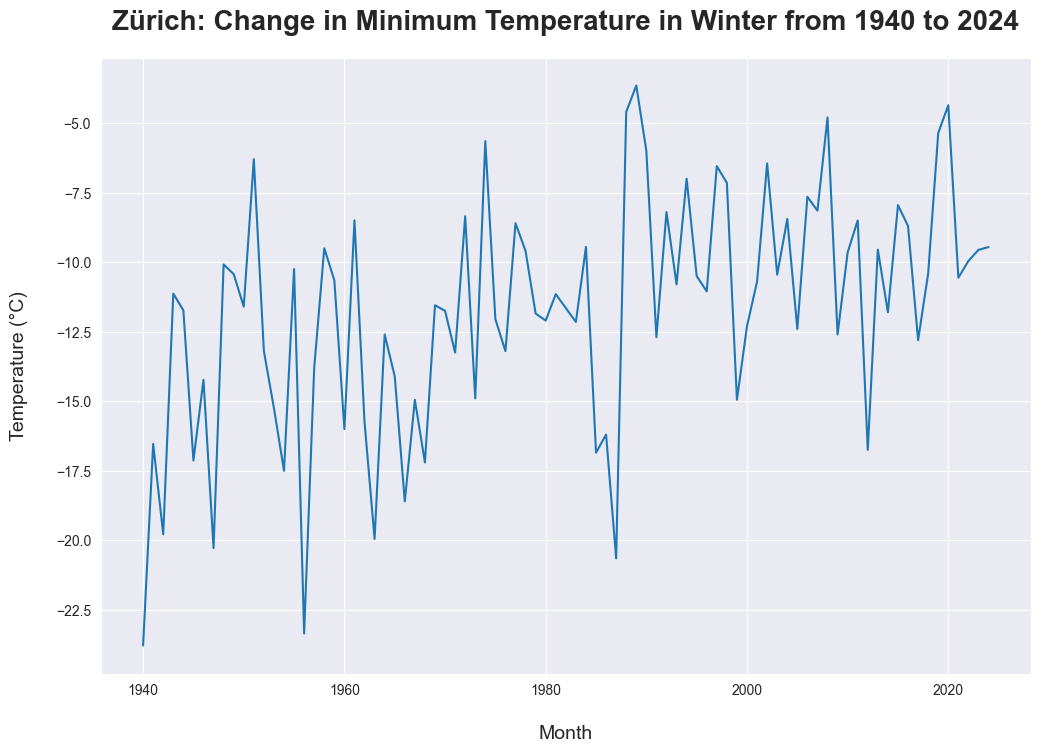

In [299]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=weather_aggregation[weather_aggregation["City"]=="Zurich"][weather_aggregation["Season"]=="Winter"], x="Year", y="min_temp")
plt.title('Zürich: Change in Minimum Temperature in Winter from 1940 to 2024', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=14, labelpad=20)  
plt.ylabel('Temperature (°C)', fontsize=14, labelpad=20)  
plt.grid(True)
plt.show()

## Wind Analysis


How windy was it, relative to the average windspeed across the dataset

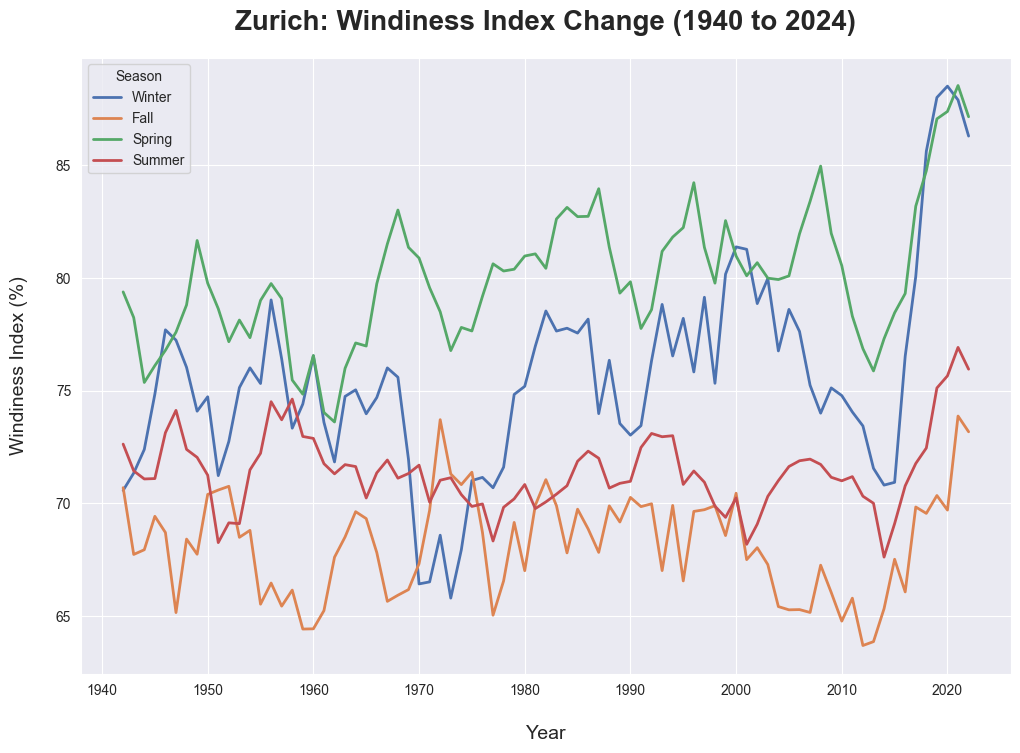

In [310]:
# Calculate the 5-year rolling average for windiness index
weather_aggregation['windiness_index_smooth'] = weather_aggregation.groupby(['City', 'Season'])['windiness_index'].transform(lambda x: x.rolling(window=5, center=True).mean())

# Plot the original windiness index and the smoothed version
plt.figure(figsize=(12, 8))

# Plot the smoothed data
sns.lineplot(data=weather_aggregation[weather_aggregation["City"] == "Zurich"], 
             x="Year", y="windiness_index_smooth", hue="Season", palette="deep", linewidth=2)

plt.title('Zurich: Windiness Index Change (1940 to 2024)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)  
plt.ylabel('Windiness Index (%)', fontsize=14, labelpad=20)  
plt.grid(True)
plt.show()

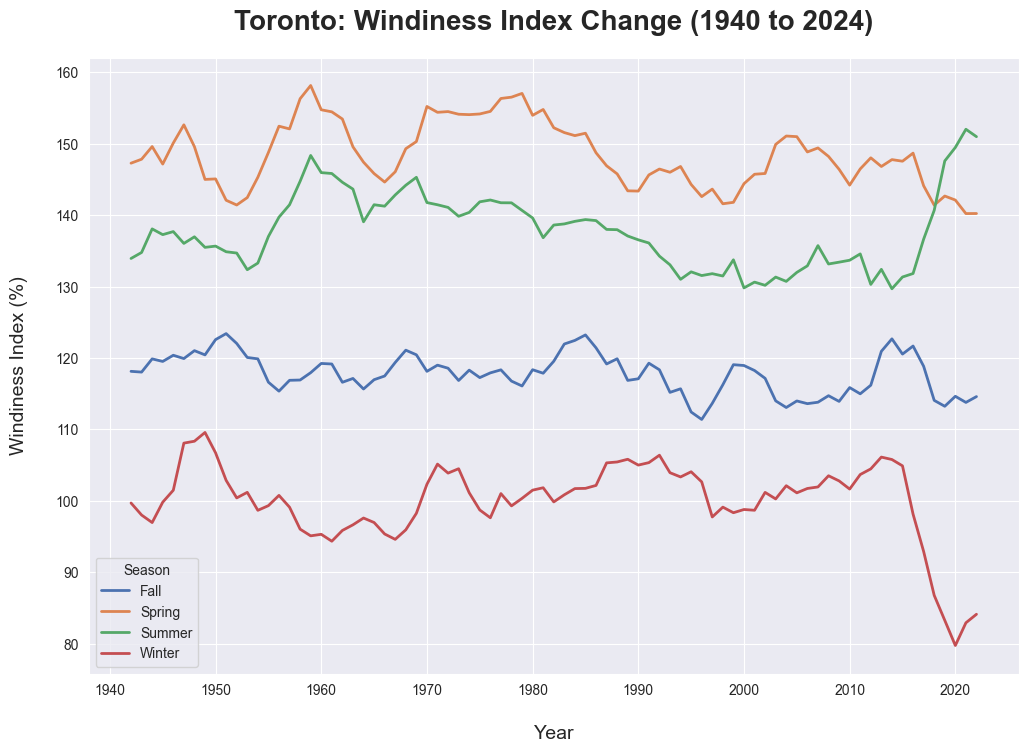

In [311]:
# Calculate the 5-year rolling average for windiness index
weather_aggregation['windiness_index_smooth'] = weather_aggregation.groupby(['City', 'Season'])['windiness_index'].transform(lambda x: x.rolling(window=5, center=True).mean())

# Plot the original windiness index and the smoothed version for Toronto
plt.figure(figsize=(12, 8))

# Plot the smoothed data for Toronto
sns.lineplot(data=weather_aggregation[weather_aggregation["City"] == "Toronto"], 
             x="Year", y="windiness_index_smooth", hue="Season", palette="deep", linewidth=2)

plt.title('Toronto: Windiness Index Change (1940 to 2024)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)  
plt.ylabel('Windiness Index (%)', fontsize=14, labelpad=20)  
plt.grid(True)
plt.show()

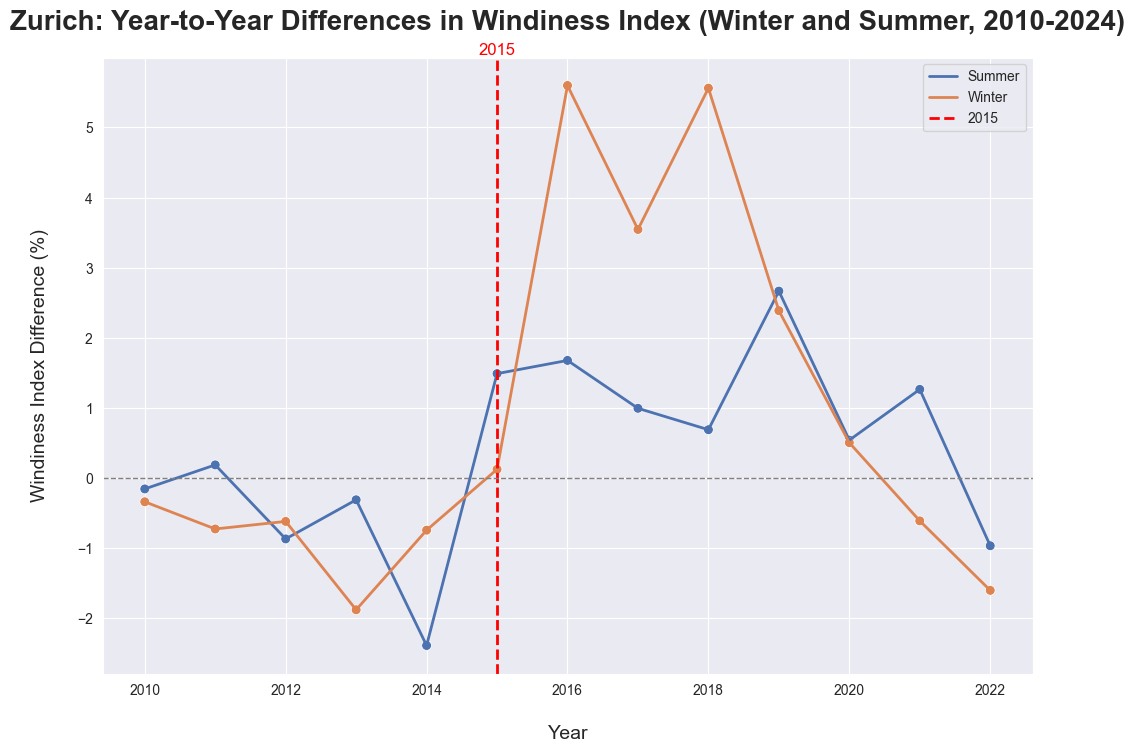

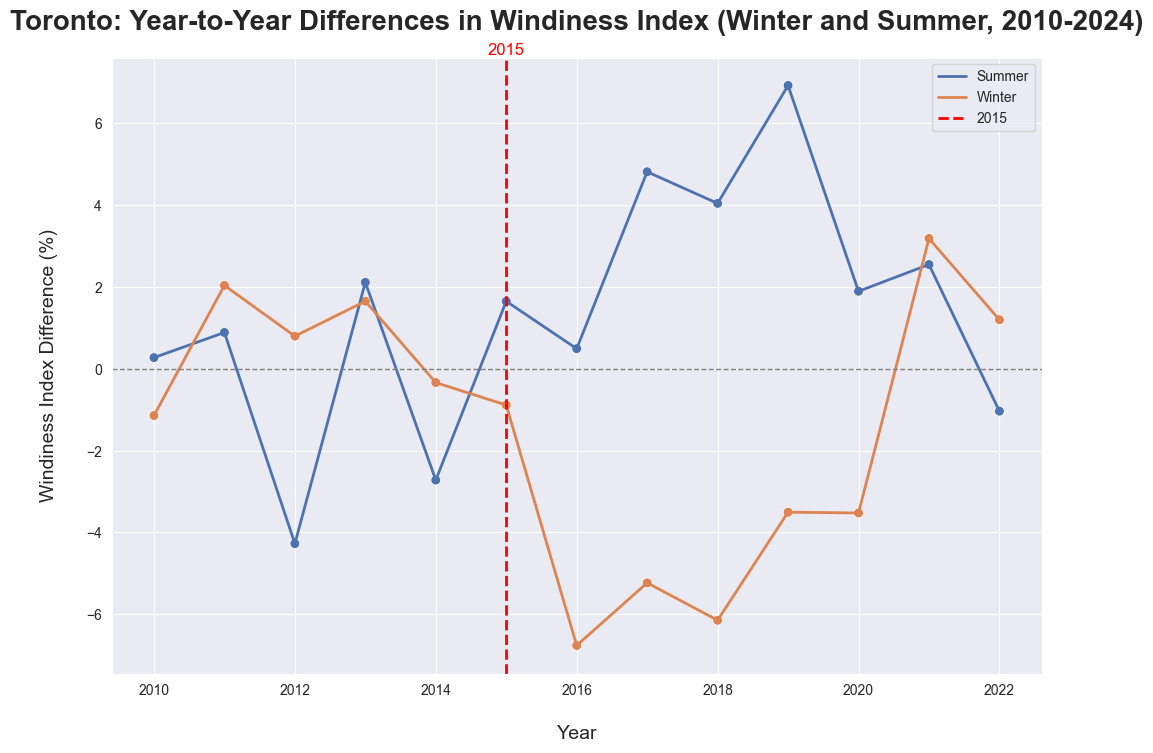

In [327]:
# Calculate the year-to-year difference in the smoothed windiness index
weather_aggregation['windiness_diff'] = weather_aggregation.groupby(['City', 'Season'])['windiness_index_smooth'].diff()

# Filter for Winter and Summer only, and for years from 2010 onwards
winter_summer_data = weather_aggregation[
    (weather_aggregation["Season"].isin(["Winter", "Summer"])) &
    (weather_aggregation["Year"] >= 2010)
]

# Plot for Zurich - Winter and Summer
plt.figure(figsize=(12, 8))
sns.lineplot(data=winter_summer_data[winter_summer_data["City"] == "Zurich"], 
             x="Year", y="windiness_diff", hue="Season", palette="deep", linewidth=2)
sns.scatterplot(data=winter_summer_data[winter_summer_data["City"] == "Zurich"], 
                x="Year", y="windiness_diff", hue="Season", palette="deep", legend=False, s=50)

# Add a vertical line at 2015 and label it
plt.axvline(x=2015, color='red', linestyle='--', linewidth=2, label='2015')
plt.text(2015, plt.ylim()[1], '2015', color='red', fontsize=12, ha='center', va='bottom')

plt.title('Zurich: Year-to-Year Differences in Windiness Index (Winter and Summer, 2010-2024)', 
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Windiness Index Difference (%)', fontsize=14, labelpad=20)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Line at zero for reference
plt.legend()
plt.grid(True)
plt.show()

# Plot for Toronto - Winter and Summer
plt.figure(figsize=(12, 8))
sns.lineplot(data=winter_summer_data[winter_summer_data["City"] == "Toronto"], 
             x="Year", y="windiness_diff", hue="Season", palette="deep", linewidth=2)
sns.scatterplot(data=winter_summer_data[winter_summer_data["City"] == "Toronto"], 
                x="Year", y="windiness_diff", hue="Season", palette="deep", legend=False, s=50)

# Add a vertical line at 2015 and label it
plt.axvline(x=2015, color='red', linestyle='--', linewidth=2, label='2015')
plt.text(2015, plt.ylim()[1], '2015', color='red', fontsize=12, ha='center', va='bottom')

plt.title('Toronto: Year-to-Year Differences in Windiness Index (Winter and Summer, 2010-2024)', 
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Windiness Index Difference (%)', fontsize=14, labelpad=20)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Line at zero for reference
plt.legend()
plt.grid(True)
plt.show()

## Wind Speed Analysis

Global ‘Stilling’: Research indicates that from 1978 until 2010, there was a worldwide decrease in wind speeds. 

In [336]:
plt.figure(figsize=(12, 8))
sns.lineplot(data = wind_aggregation, x = "Year", y = "mean_gust_factor" , hue = "City", marker="o" )
plt.title("Gust Factor Comparison Seattle Zurich", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, labelpad=20)
plt.ylabel("Gust Factor", fontsize=14, labelpad=20)


ValueError: Could not interpret value `mean_gust_factor` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x800 with 0 Axes>

Global ‘Stilling’: Research indicates that from 1978 until 2010, there was a worldwide decrease in wind speeds. La Niña Events. Calculate the Windiness Index:
Divide the annual mean wind speed by the long-term average wind speed, then multiply by 100 to express it as a percentage: ￼
Annual Mean windspeed/Dataset average ) * 100 = Compare windpseed in comparison to alltime average


## Sunshine and Cloudiness Analysis


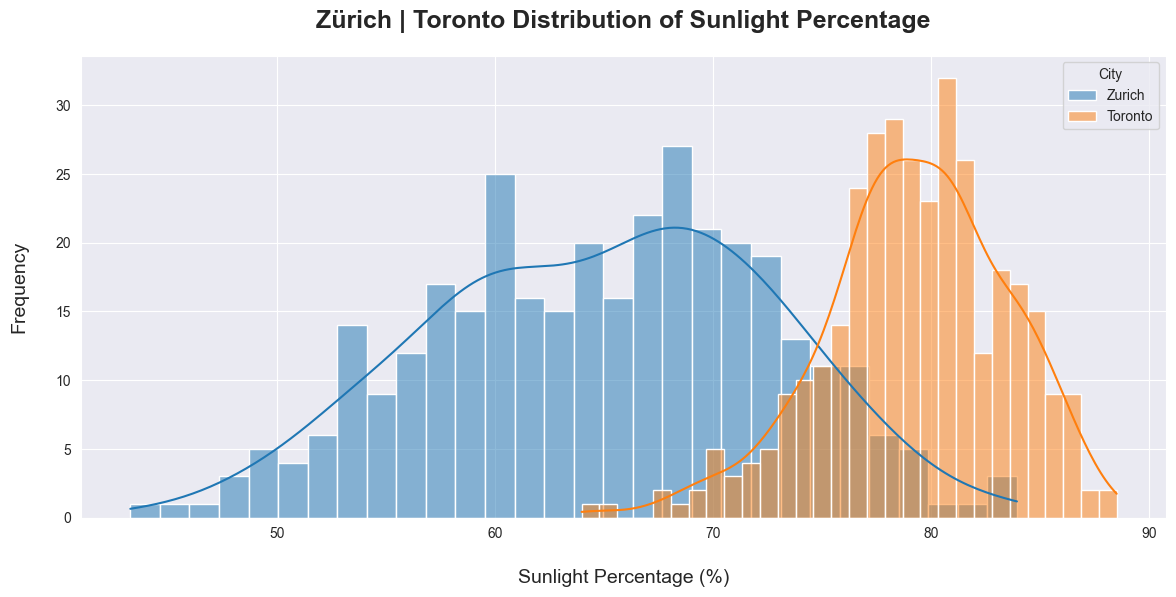

In [328]:
# Check the distribution before fitting a model
plt.figure(figsize=(14, 6))

# Plot for Zurich with a label
sns.histplot(weather_aggregation[weather_aggregation["City"] == "Zurich"]["mean_sunlight_percentage"], bins=30, kde=True, label="Zurich")

# Plot for Toronto with a label
sns.histplot(weather_aggregation[weather_aggregation["City"] == "Toronto"]["mean_sunlight_percentage"], bins=30, kde=True, label="Toronto")

# Title and labels
plt.title("Zürich | Toronto Distribution of Sunlight Percentage", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Sunlight Percentage (%)", fontsize=14, labelpad=20)
plt.ylabel("Frequency", fontsize=14, labelpad=20)

# Add a legend to differentiate between cities
plt.legend(title="City")
plt.show()



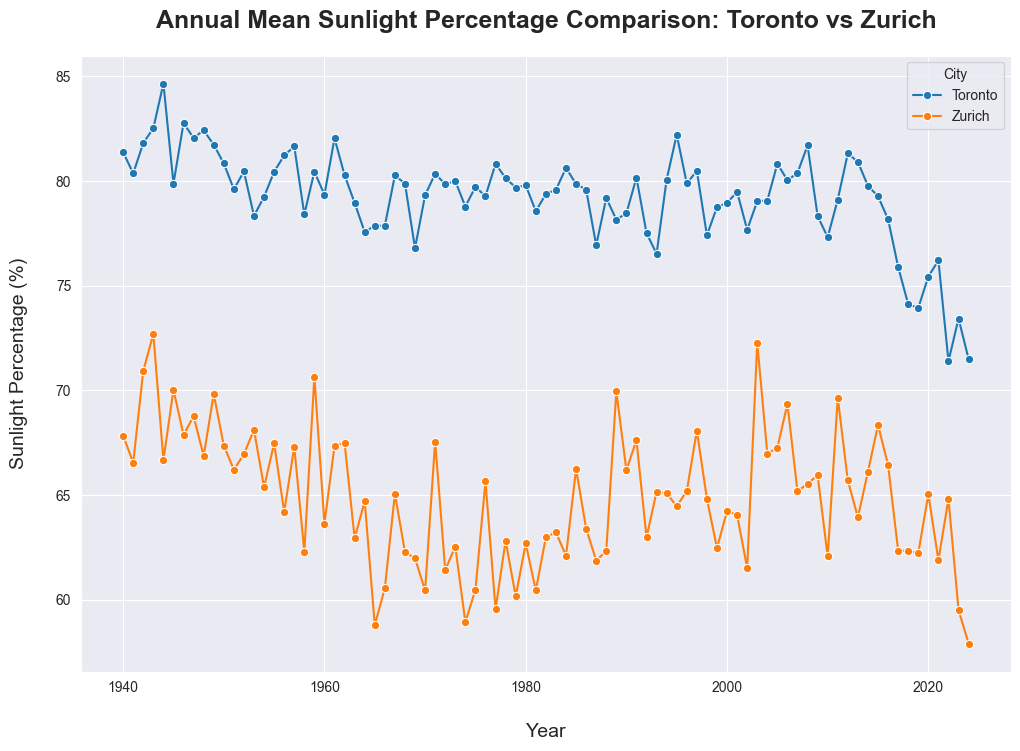

In [334]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=weather_aggregation, x="Year", y="mean_sunlight_percentage", hue="City", marker="o",  errorbar=None)
plt.title("Annual Mean Sunlight Percentage Comparison: Toronto vs Zurich", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, labelpad=20)
plt.ylabel("Sunlight Percentage (%)", fontsize=14, labelpad=20)
plt.show()

Fitted Parameters: A=-2.940, B=0.113, C=-27.116, D=64.477


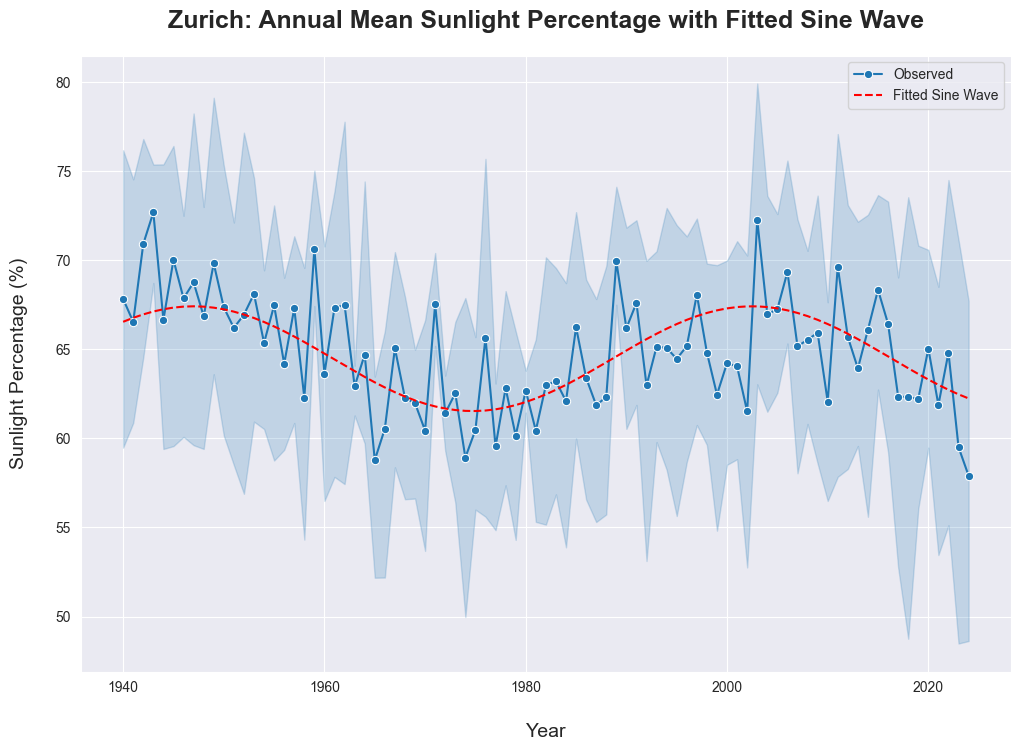

In [332]:
# Define the sine wave function
def sine_function(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

# Filter Zurich data from the aggregated dataframe
zurich_sunlight = weather_aggregation[weather_aggregation["City"] == "Zurich"]

# Remove NaN and infinite values
zurich_sunlight = zurich_sunlight[np.isfinite(zurich_sunlight["mean_sunlight_percentage"])]

# Initial guesses for amplitude (A), frequency (B), phase shift (C), and vertical shift (D)
initial_guess = [10, 0.1, 0, 70]

# Fit the sine function to the data
params, _ = curve_fit(sine_function, zurich_sunlight["Year"], zurich_sunlight["mean_sunlight_percentage"], p0=initial_guess)

# Extract the fitted parameters
A, B, C, D = params
print(f"Fitted Parameters: A={A:.3f}, B={B:.3f}, C={C:.3f}, D={D:.3f}")

# Generate fitted sine wave values
fitted_sine = sine_function(zurich_sunlight["Year"], A, B, C, D)

# Plot the original data and the fitted sine wave
plt.figure(figsize=(12, 8))
sns.lineplot(data=zurich_sunlight, x="Year", y="mean_sunlight_percentage", label="Observed", marker="o")
plt.plot(zurich_sunlight["Year"], fitted_sine, color="red", linestyle="--", label="Fitted Sine Wave")

# Add titles and labels
plt.title("Zurich: Annual Mean Sunlight Percentage with Fitted Sine Wave", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, labelpad=20)
plt.ylabel("Sunlight Percentage (%)", fontsize=14, labelpad=20)
plt.legend()

# Show the plot
plt.show()

## Drought Index Comparison

The Drought Index measures the difference between water loss from evapotranspiration (ET0) and water input from precipitation. A positive value means more water is lost than gained, indicating drought conditions, while a negative value shows a surplus where precipitation outweighs water loss. 

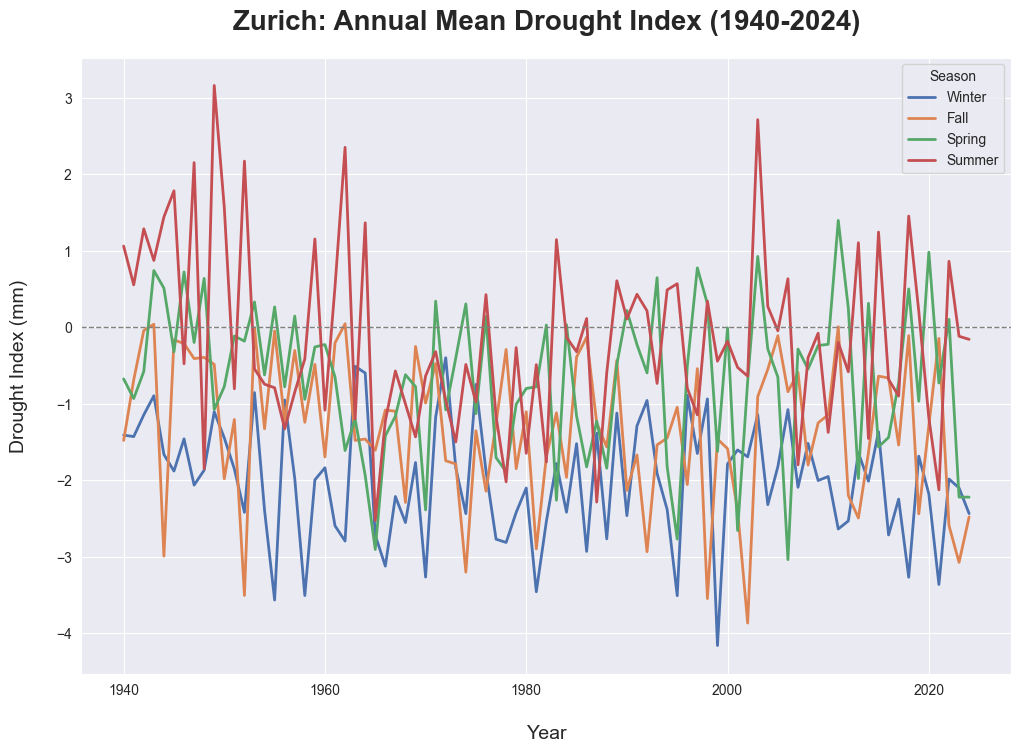

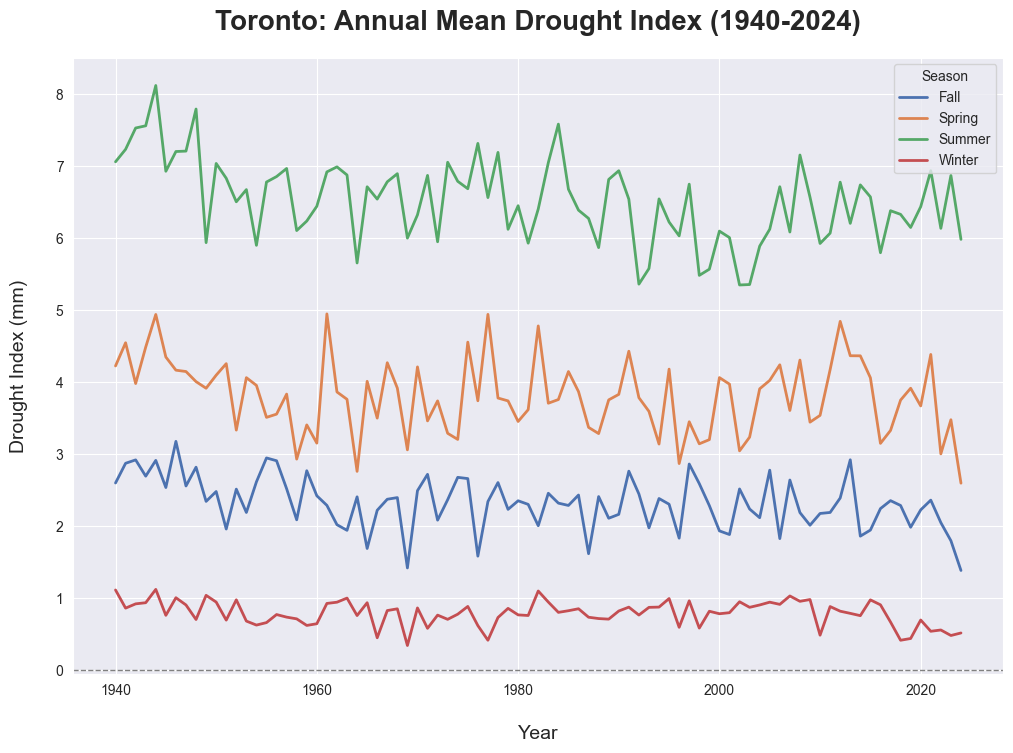

In [342]:
# Plot: Annual Mean Drought Index for Zurich
plt.figure(figsize=(12, 8))
sns.lineplot(data=weather_aggregation[weather_aggregation["City"] == "Zurich"], 
             x="Year", y="mean_drought_index", hue="Season", palette="deep", linewidth=2)
plt.title('Zurich: Annual Mean Drought Index (1940-2024)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Drought Index (mm)', fontsize=14, labelpad=20)  # Added unit (mm)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

# Plot: Annual Mean Drought Index for Toronto
plt.figure(figsize=(12, 8))
sns.lineplot(data=weather_aggregation[weather_aggregation["City"] == "Toronto"], 
             x="Year", y="mean_drought_index", hue="Season", palette="deep", linewidth=2)
plt.title('Toronto: Annual Mean Drought Index (1940-2024)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.ylabel('Drought Index (mm)', fontsize=14, labelpad=20)  # Added unit (mm)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()